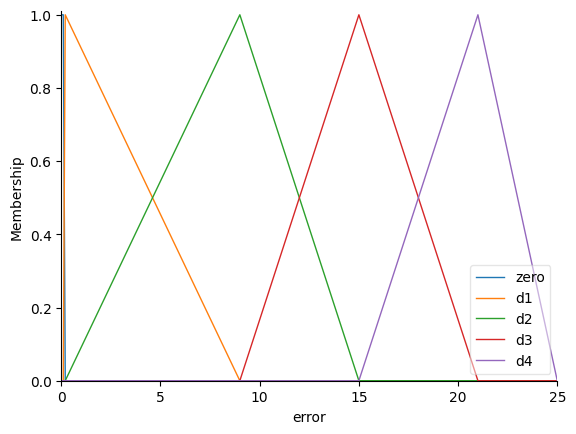

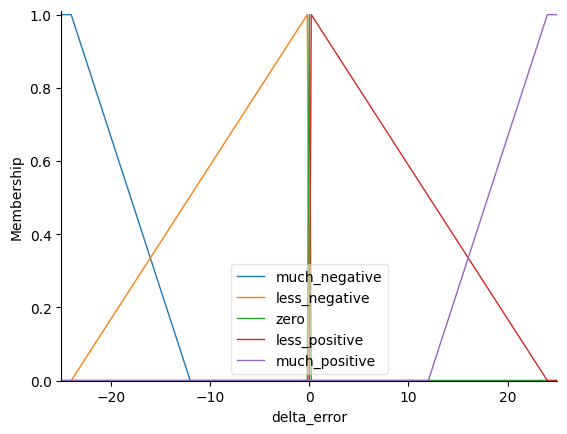

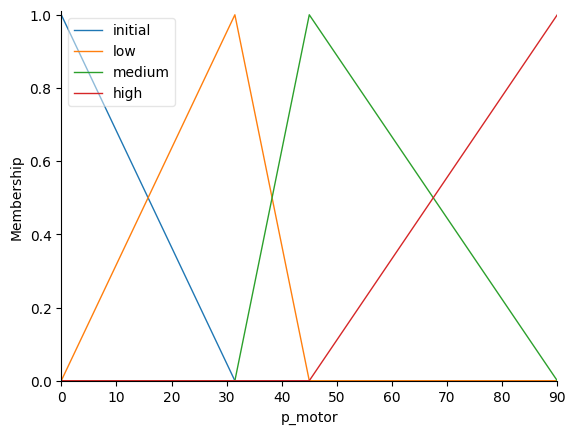

In [40]:
from flask import Flask, request, jsonify
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

app = Flask(__name__)

# Define fuzzy variables
error = ctrl.Antecedent(np.arange(0, 25.01, 0.01), 'error')
delta_error = ctrl.Antecedent(np.arange(-25, 25.1, 0.1), 'delta_error')
p_motor = ctrl.Consequent(np.arange(0, 90.5, 0.5), 'p_motor')

# Define membership functions for error
error['zero'] = fuzz.trapmf(error.universe, [0, 0, 0.1, 0.2]) # Representa quase nenhum erro.
error['d1'] = fuzz.trimf(error.universe, [0.10, 0.2, 9]) # Pequeno erro, cobrindo deslocamentos curtos.
error['d2'] = fuzz.trimf(error.universe, [0.2, 9, 15]) # Erro médio.
error['d3'] = fuzz.trimf(error.universe, [9, 15, 21]) # Grande erro.
error['d4'] = fuzz.trimf(error.universe, [15, 21, 25]) # Erro muito grande, próximo do limite máximo considerado.

# Define membership functions for delta_error
delta_error['much_negative'] = fuzz.trapmf(delta_error.universe, [-50, -50, -24, -12]) # Mudança de erro muito negativa, indicando uma rápida descida.
delta_error['less_negative'] = fuzz.trimf(delta_error.universe, [-24, -0.2, 0]) # - Mudança de erro levemente negativa.
delta_error['zero'] = fuzz.trimf(delta_error.universe, [-0.2, 0, 0.2]) # Nenhuma mudança significativa no erro.
delta_error['less_positive'] = fuzz.trimf(delta_error.universe, [0, 0.2, 24]) # Mudança de erro levemente positiva.
delta_error['much_positive'] = fuzz.trapmf(delta_error.universe, [12, 24, 50, 50]) # Mudança de erro muito positiva, indicando uma rápida subida.

# Define membership functions for p_motor
p_motor['initial'] = fuzz.trimf(p_motor.universe, [0, 0, 31.5]) #  Potência inicial para tirar o elevador da inércia.
p_motor['low'] = fuzz.trimf(p_motor.universe, [0, 31.5, 45]) # Baixa potência.
p_motor['medium'] = fuzz.trimf(p_motor.universe, [31.5, 45, 90]) #  Potência média.
p_motor['high'] = fuzz.trimf(p_motor.universe, [45, 90, 90]) # Alta potência.

error.view()
delta_error.view()
p_motor.view()

# Define fuzzy rules
rule1 = ctrl.Rule(error['zero'] & delta_error['much_negative'], p_motor['initial'])
rule2 = ctrl.Rule(error['zero'] & delta_error['less_negative'], p_motor['initial'])
rule3 = ctrl.Rule(error['zero'] & delta_error['zero'], p_motor['initial'])
rule4 = ctrl.Rule(error['zero'] & delta_error['less_positive'], p_motor['initial'])
rule5 = ctrl.Rule(error['zero'] & delta_error['much_positive'], p_motor['initial'])
rule6 = ctrl.Rule(error['d1'] & delta_error['much_negative'], p_motor['low'])
rule7 = ctrl.Rule(error['d1'] & delta_error['less_negative'], p_motor['low'])
rule8 = ctrl.Rule(error['d1'] & delta_error['zero'], p_motor['initial'])
rule9 = ctrl.Rule(error['d1'] & delta_error['less_positive'], p_motor['low'])
rule10 = ctrl.Rule(error['d1'] & delta_error['much_positive'], p_motor['low'])
rule11 = ctrl.Rule(error['d2'] & delta_error['much_negative'], p_motor['medium'])
rule12 = ctrl.Rule(error['d2'] & delta_error['less_negative'], p_motor['medium'])
rule13 = ctrl.Rule(error['d2'] & delta_error['zero'], p_motor['initial'])
rule14 = ctrl.Rule(error['d2'] & delta_error['less_positive'], p_motor['medium'])
rule15 = ctrl.Rule(error['d2'] & delta_error['much_positive'], p_motor['medium'])
rule16 = ctrl.Rule(error['d3'] & delta_error['much_negative'], p_motor['high'])
rule17 = ctrl.Rule(error['d3'] & delta_error['less_negative'], p_motor['high'])
rule18 = ctrl.Rule(error['d3'] & delta_error['zero'], p_motor['initial'])
rule19 = ctrl.Rule(error['d3'] & delta_error['less_positive'], p_motor['high'])
rule20 = ctrl.Rule(error['d3'] & delta_error['much_positive'], p_motor['high'])
rule21 = ctrl.Rule(error['d4'] & delta_error['much_negative'], p_motor['high'])
rule22 = ctrl.Rule(error['d4'] & delta_error['less_negative'], p_motor['high'])
rule23 = ctrl.Rule(error['d4'] & delta_error['zero'], p_motor['initial'])
rule24 = ctrl.Rule(error['d4'] & delta_error['less_positive'], p_motor['high'])
rule25 = ctrl.Rule(error['d4'] & delta_error['much_positive'], p_motor['high'])

# Control system
elevator_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20, rule21, rule22, rule23, rule24, rule25])
elevator = ctrl.ControlSystemSimulation(elevator_ctrl)

In [43]:
elevator.input['error'] = 5
elevator.input['delta_error'] = -15

elevator.compute()

print(elevator.output['p_motor'])

43.80520293223667


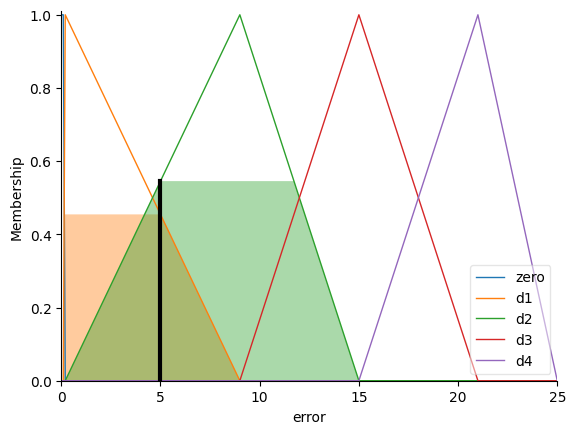

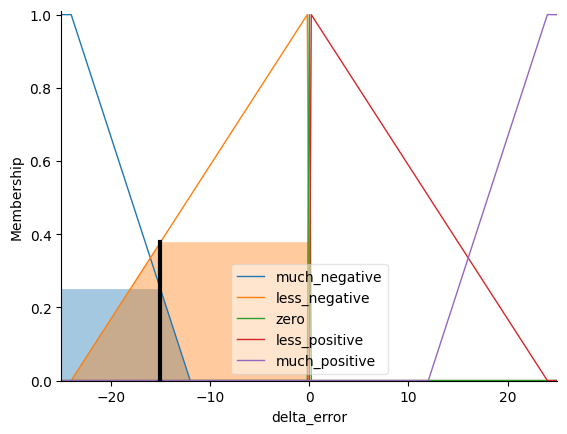

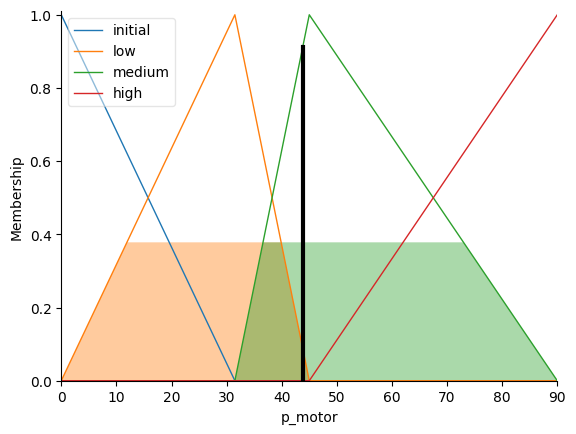

In [44]:
error.view(sim = elevator)
delta_error.view(sim = elevator)
p_motor.view(sim = elevator)

In [10]:
def update_position(current_position, desired_position, e, de):
    if (e == 0 and de == 0):
        return current_position
    
    elevator.input['error'] = e
    elevator.input['delta_error'] = de
    elevator.compute()
    position, _ = [[current_position], current_position]
    new_position = current_position
    for time in np.arange(0.1, 3.1, 0.1):
        power = time * 0.315 / 3
        new_position = new_position * (1 if e >= 0 else -1) + power * 0.00951
        if time == round(time, 0):
            position = np.append(position, new_position)
        
    previous_error = desired_position - new_position
    
    for _ in np.arange(3, 400, 1):
        e = desired_position - new_position
        current_error = abs(e)
        elevator.input[error.label] = current_error
        
        current_delta_error = previous_error - current_error
        elevator.input[delta_error.label] = current_delta_error
        
        elevator.compute()
        power = elevator.output['p_motor']
        new_position = abs(new_position * 0.996 * (1 if e >= 0 else -1) + power * 0.00951)
        
        position = np.append(position, new_position)
        previous_error = current_error
        
    if (desired_position > current_position):
        ymin, ymax = [current_position - 3, max(position) * 1.25]
    else:
        ymin, ymax = [min(position) * 0.75, current_position + 3]
        
    return new_position

# Flask endpoint to handle control requests
@app.route('/control', methods=['POST'])
def control():
    data = request.json
    current_position = data['body']['current_position']
    desired_position = data['body']['desired_position']
    previous_error = data['body']['previous_error']
    is_staff = data['body']['is_staff']
    last_digit = data['body']['last_digit']
    
    print(f'Current position: {current_position}, Desired position: {desired_position}, Is staff: {is_staff}, last digit: {last_digit}')
    
    if (is_staff == False and (desired_position == 0 or desired_position == 32)):
        is_staff = True
        new_position = current_position
        print(f'Is staff: {is_staff}')
    elif (is_staff == True and (desired_position != 0 and desired_position != 32)):
        if (last_digit == 0 and desired_position == 8):
            new_position = current_position
        elif (last_digit == 32 and desired_position == 23):
            new_position = current_position
        elif (last_digit == 23 and desired_position == 4):
            desired_position = 32
            is_staff = False
        elif (last_digit == 8 and desired_position == 20):
            desired_position = 0
            is_staff = False
        else:
            is_staff = False
            
    if (is_staff == False):      
        e = desired_position - current_position
        de = e - previous_error
        new_position = update_position(current_position, desired_position, e, de)
        previous_error = e
        
    print(f'Current position: {current_position}, Desired position: {desired_position}, Is staff: {is_staff}, last digit: {last_digit}')
    
    response = {
        'current_position': new_position,
        'previous_error': previous_error,
        'is_staff': is_staff,
        'last_digit': desired_position
    }
    return jsonify(response)

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.31.153:5000
Press CTRL+C to quit
